In our project, we worked on optimizing the cost, savings and energy consumption of Heat recovery System (HRS).There are various number of compressors and areas used in 6 months that are involved in the HRS. We have done this optimization formulation using mixed integer linear programming (MILP) model. 

In [1]:
%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import numpy as np
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 20.8 MB/s 


We are increasing the number of compressors to evaluate how the cost and savings are affected. Here for simplicity we have done this change staticly for each of the compressors.

In [2]:
#This cell is for checking the optimized cost for the number of compressor= 6, number of areas =6 and number of planning periods in months=6

#####                Sets and Indices         #############
compressor = 6
area = 6
period= 6  

#####               Input Parameters           ##########

#unit heating cost in the months 
hc=[10.5,11,15,14.8,16, 17]
#unit cooling cost in the months
cc=[11.5,11.5,13,9.8,10,16]
## investment cost of the heating system installation of the area
f=[15000, 15500, 20200, 18760, 15000, 12000]
#Marginal cost of the j compressor added
S=[12000,13500,12500,14600,15400,15000]

#Average energy consumption in Mega Watt to heat up the area i in month m

## Because of 6 areas and 6 periods, there are lots of indexes in the E multidictionary,for simplicity, instead of assigning all the values of E manually,
## here we used randint() function to produce random values of E between 2000 to 5000. Because of the several randint() function the optimization
## output giving slightly different values in each time of running the codes
E = {}
for i in range(area):    
    for m in range(period):    
        E[i,m] = random.randint(2000,5000) 

#Average energy consumption in Mega Watt to cool down the compressor j in month m
D={}
for j in range(compressor):    
   for m in range(period):    
        D[j,m] = random.randint(2000,5000) 

#extra energy consumption to heat up the area in m month
A=[1120,1130,1120.5,1030,1125.5,1128, 1125,1130, 1122,1125]
#extra energy consumption to cool down the compressor in m month
B=[1120.5,1030.5,1018.5,1122,1125.5,1026, 1120.5,1030, 1122,1225]

## Fixed investment cost for piping system of the area k to i
P={}
stored_key=[]
for k in range(area):    
    for i in range(area):    
        stored_key=P.keys()
        P[k,i] = random.randint(1000,2000) 

# Average energy loss from area i to area k in month m
L = {}
for k in range(area):    
    for i in range(area): 
     for m in range(period):  
       L[k,i,m] = random.randint(0,200) 

########    Model Deployment   #############
model = gp.Model('HRS')

#####          Decison Variable   ############
x = model.addVars(area, vtype=GRB.BINARY, name="x")
y = model.addVars(compressor, vtype=GRB.BINARY, name="y")
z = model.addVars(stored_key, vtype=GRB.BINARY, name="z")

#######     Assignment Constraint ##################
assignment1 =  model.addConstr(gp.quicksum(x[i] for i in range(area)) >= 1)
assignment2 =  model.addConstr(gp.quicksum(y[j] for j in range(compressor)) >= 1)
assignment3 =  model.addConstr(x[0] == 1)
assignment4 =  model.addConstrs((y[j-1] - y[j])  >= 0 for j in range(2,compressor) )

####         Routing Constraint  ##############
routing1 = model.addConstrs(gp.quicksum(z[k,i] for i in range(area)) <= 1 for k in range (area) if k != i)
routing2 = model.addConstrs(gp.quicksum(z[k,i] for k in range(area)) <= 1 for i in range (area) if i != k)
routing3 = model.addConstrs(x[i] - gp.quicksum(z[k,i] for k in range (area)) == 0 for i in range(area) if i != k)
routing4 = model.addConstrs(z[k,i]+z[i,k] <= 1 for k in range (area) for i in range(area) if k!=i )
  
#########          New Energy Consumption Constaint   ########

e1 = model.addConstrs(gp.quicksum(D[j,m]*y[j] for j in range(compressor)) <= 20000 for m in range(period))
e2 = model.addConstrs(gp.quicksum(E[i,m]*x[i] for i in range(area)) <= 20000 for m in range(period))
e3 = model.addConstrs(gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area))  <= 1500 for m in range(period) if k!=i)

###############            Objective: Minimize total cost of HRS installation                ##########

### z1=Extra cost of cooling down for the compressors and heating up the areas
z1 = gp.quicksum(cc[m]*B[m] for m in range(period)) + gp.quicksum(hc[m]*A[m] for m in range(period))

### z2= Extra cost of additional areas and compressors that are not assigned to HRS
z2 = gp.quicksum(cc[m]* D[j,m]*(1-y[j]) for m in range(period) for j in range(compressor)) + gp.quicksum(hc[m]* E[i,m]*(1-x[i]) for m in range(period) for i in range(area)) 

### z3= Investment cost (Installation cost)
z3=  gp.quicksum(x[i]*f[i] for i in range(area)) + gp.quicksum(z[k,i]*P[k,i] for k in range(area) for i in range(area) if k!=i)

### z4= Investment cost (Marginal cost of adding extra compressors)
z4=  gp.quicksum(y[j]* S[j]  for j in range(compressor))

#### z5= Total cost for HRS installation 
z5= gp.quicksum(cc[m]* D[j,m]* y[j] for m in range(period) for j in range(compressor)) + gp.quicksum(hc[m]* E[i,m]*x[i] for m in range(period) for i in range(area)) 

##New  Objective: Minimize Energy Consumption  #############

### z6= Total energy Consumption for the HRS
z6= gp.quicksum(D[j,m]*y[j] for j in range(compressor) for m in range(period)) +  gp.quicksum(E[i,m]*x[i] for i in range(area)for m in range(period)) - gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area) for m in range(period) )

### Objective 1:Minimization of costs ####
model.setObjective((z1+z2+z3+z4), GRB.MINIMIZE)
model.write('junk.lp')
model.optimize()

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 64 rows, 48 columns and 248 nonzeros
Model fingerprint: 0x6e8aafe6
Variable types: 0 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+03, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 1906651.7000
Presolve removed 48 rows and 24 columns
Presolve time: 0.00s
Presolved: 16 rows, 24 columns, 66 nonzeros
Found heuristic solution: objective 857573.50000
Variable types: 0 continuous, 24 integer (24 binary)

Root relaxation: cutoff, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl | 

In [3]:
#This cell is for checking the optimized cost for the number of compressor= 8, number of areas =6 and number of planning periods in months=6

#####                Sets and Indices         #############
##increasing the number of compressors
compressor = 8
area = 6
period= 6  

#####               Input Parameters           ##########

#unit heating cost in the months 
hc=[10.5,11,15,14.8,16, 17]
#unit cooling cost in the months
cc=[11.5,11.5,13,9.8,10,16]
## investment cost of the heating system installation of the area
f=[15000, 15500, 20200, 18760, 15000, 12000]
# Marginal cost of the j compressor added
S=[12000,13500,12500,14600,15400,15000,14600,15800]

#Average energy consumption in Mega Watt to heat up the area i in month m
## Because of 6 areas and 6 periods, there are lots of indexes in the E multidictionary,for simplicity, instead of assigning all the values of E manually,
## here we used randint() function to produce random values of E between 2000 to 5000. Because of the several randint() function the optimization
## output gives slight different result in each time of running the codes
E = {}
for i in range(area):    
    for m in range(period):    
        E[i,m] = random.randint(2000,5000) 

#Average energy consuption in Mega Watt to cool down the compressor j in month m
D={}
for j in range(compressor):    
   for m in range(period):    
        D[j,m] = random.randint(2000,5000) 

#extra energy consumption to heat up the area in m month
A=[1120,1130,1120.5,1030,1125.5,1128, 1125,1130, 1122,1125]
#extra energy consumption to cool down the compressor in m month
B=[1120.5,1030.5,1018.5,1122,1125.5,1026, 1120.5,1030, 1122,1225]

## Fixed investment cost for piping system of the area k to i
P={}
stored_key=[]
for k in range(area):    
    for i in range(area):    
        stored_key=P.keys()
        P[k,i] = random.randint(1000,2000) 

# Average energy loss from area i to area k in month m
L = {}
for k in range(area):    
    for i in range(area): 
     for m in range(period):  
       L[k,i,m] = random.randint(0,200) 

########    Model Deployment   #############
model = gp.Model('HRS')

#####          Decison Variable   ############
x = model.addVars(area, vtype=GRB.BINARY, name="x")
y = model.addVars(compressor, vtype=GRB.BINARY, name="y")
z = model.addVars(stored_key, vtype=GRB.BINARY, name="z")

#######     Assignment Constraint ##################
assignment1 =  model.addConstr(gp.quicksum(x[i] for i in range(area)) >= 1)
assignment2 =  model.addConstr(gp.quicksum(y[j] for j in range(compressor)) >= 1)
assignment3 =  model.addConstr(x[0] == 1)
assignment4 =  model.addConstrs((y[j-1] - y[j])  >= 0 for j in range(2,compressor) )

####         Routing Constraint  ##############
routing1 = model.addConstrs(gp.quicksum(z[k,i] for i in range(area)) <= 1 for k in range (area) if k != i)
routing2 = model.addConstrs(gp.quicksum(z[k,i] for k in range(area)) <= 1 for i in range (area) if i != k)
routing3 = model.addConstrs(x[i] - gp.quicksum(z[k,i] for k in range (area)) == 0 for i in range(area) if i != k)
routing4 = model.addConstrs(z[k,i]+z[i,k] <= 1 for k in range (area) for i in range(area) if k!=i )
  
#########          New Energy Consumption Constaint   ########

e1 = model.addConstrs(gp.quicksum(D[j,m]*y[j] for j in range(compressor)) <= 20000 for m in range(period))
e2 = model.addConstrs(gp.quicksum(E[i,m]*x[i] for i in range(area)) <= 20000 for m in range(period))
e3 = model.addConstrs(gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area))  <= 1500 for m in range(period) if k!=i)

###############            Objective: Minimize total cost of HRS installation                ##########

### z1=Extra cost of cooling down for the compressors and heating up the areas
z1 = gp.quicksum(cc[m]*B[m] for m in range(period)) + gp.quicksum(hc[m]*A[m] for m in range(period))

### z2= Extra cost of additional areas and compressors that are not assigned to HRS
z2 = gp.quicksum(cc[m]* D[j,m]*(1-y[j]) for m in range(period) for j in range(compressor)) + gp.quicksum(hc[m]* E[i,m]*(1-x[i]) for m in range(period) for i in range(area)) 

### z3= Investment cost (Installation cost)
z3=  gp.quicksum(x[i]*f[i] for i in range(area)) + gp.quicksum(z[k,i]*P[k,i] for k in range(area) for i in range(area) if k!=i)

### z4= Investment cost (Marginal cost of adding extra compressors)
z4=  gp.quicksum(y[j]* S[j]  for j in range(compressor))

#### z5= Total cost for HRS installation 
z5= gp.quicksum(cc[m]* D[j,m]* y[j] for m in range(period) for j in range(compressor)) + gp.quicksum(hc[m]* E[i,m]*x[i] for m in range(period) for i in range(area)) 

##New  Objective: Minimize Energy Consumption  #############

### z6= Total energy Consumption for the HRS
z6= gp.quicksum(D[j,m]*y[j] for j in range(compressor) for m in range(period)) +  gp.quicksum(E[i,m]*x[i] for i in range(area)for m in range(period)) - gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area) for m in range(period) )

### Objective 1: Minimization of costs ####
model.setObjective((z1+z2+z3+z4), GRB.MINIMIZE)
model.write('junk.lp')
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 66 rows, 50 columns and 266 nonzeros
Model fingerprint: 0x1c5a33f7
Variable types: 0 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+03, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 2363895.2000
Presolve removed 62 rows and 46 columns
Presolve time: 0.00s
Presolved: 4 rows, 4 columns, 11 nonzeros
Found heuristic solution: objective 1556088.2000
Variable types: 0 continuous, 4 integer (4 binary)

Root relaxation: objective 1.345945e+06, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node T

In [4]:
#This cell is for checking the optimized cost for the number of compressor= 10, number of areas =6 and number of planning periods in months=6

#####                Sets and Indices         #############
##increasing the number of compressors
compressor = 10
area = 6
period= 6  

#####               Input Parameters           ##########

#unit heating cost in the months 
hc=[10.5,11,15,14.8,16, 17]
#unit cooling cost in the months
cc=[11.5,11.5,13,9.8,10,16]
## investment cost of the heating system installation of the area
f=[15000, 15500, 20200, 18760, 15000, 12000]
# Marginal cost of the j compressor added
S=[12000,13500,12500,14600,15400,15000,14600,15800,14600,15400]

#Average energy consuption in Mega Watt to heat up the area i in month m
## Because of 6 areas and 6 periods, there are lots of indexes in the E multidictionary,for simplicity, instead of assigning all the values of E manually,
## here we used randint() function to produce random values of E between 2000 to 5000. Because of the several randint() function the optimization
## output gives slight different result in each time of running the codes
E = {}
for i in range(area):    
    for m in range(period):    
        E[i,m] = random.randint(2000,5000) 

#Average energy consuption in Mega Watt to cool down the compressor j in month m
D={}
for j in range(compressor):    
   for m in range(period):    
        D[j,m] = random.randint(2000,5000) 

#extra energy consumption to heat up the area in m month
A=[1120,1130,1120.5,1030,1125.5,1128, 1125,1130, 1122,1125]
#extra energy consumption to cool down the compressor in m month
B=[1120.5,1030.5,1018.5,1122,1125.5,1026, 1120.5,1030, 1122,1225]

## Fixed investment cost for piping system of the area k to i
P={}
stored_key=[]
for k in range(area):    
    for i in range(area):    
        stored_key=P.keys()
        P[k,i] = random.randint(1000,2000) 

# Average energy loss from area i to area k in month m
L = {}
for k in range(area):    
    for i in range(area): 
     for m in range(period):  
       L[k,i,m] = random.randint(0,200) 

########    Model Deployment   #############
model = gp.Model('HRS')

#####          Decison Variable   ############
x = model.addVars(area, vtype=GRB.BINARY, name="x")
y = model.addVars(compressor, vtype=GRB.BINARY, name="y")
z = model.addVars(stored_key, vtype=GRB.BINARY, name="z")

#######     Assignment Constraint ##################
assignment1 =  model.addConstr(gp.quicksum(x[i] for i in range(area)) >= 1)
assignment2 =  model.addConstr(gp.quicksum(y[j] for j in range(compressor)) >= 1)
assignment3 =  model.addConstr(x[0] == 1)
assignment4 =  model.addConstrs((y[j-1] - y[j])  >= 0 for j in range(2,compressor) )

####         Routing Constraint  ##############
routing1 = model.addConstrs(gp.quicksum(z[k,i] for i in range(area)) <= 1 for k in range (area) if k != i)
routing2 = model.addConstrs(gp.quicksum(z[k,i] for k in range(area)) <= 1 for i in range (area) if i != k)
routing3 = model.addConstrs(x[i] - gp.quicksum(z[k,i] for k in range (area)) == 0 for i in range(area) if i != k)
routing4 = model.addConstrs(z[k,i]+z[i,k] <= 1 for k in range (area) for i in range(area) if k!=i )
  
#########          New Energy Consumption Constaint   ########

e1 = model.addConstrs(gp.quicksum(D[j,m]*y[j] for j in range(compressor)) <= 20000 for m in range(period))
e2 = model.addConstrs(gp.quicksum(E[i,m]*x[i] for i in range(area)) <= 20000 for m in range(period))
e3 = model.addConstrs(gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area))  <= 1500 for m in range(period) if k!=i)

###############            Objective: Minimize total cost of HRS installation                ##########

### z1=Extra cost of cooling down for the compressors and heating up the areas
z1 = gp.quicksum(cc[m]*B[m] for m in range(period)) + gp.quicksum(hc[m]*A[m] for m in range(period))

### z2= Extra cost of additional areas and compressors that are not assigned to HRS
z2 = gp.quicksum(cc[m]* D[j,m]*(1-y[j]) for m in range(period) for j in range(compressor)) + gp.quicksum(hc[m]* E[i,m]*(1-x[i]) for m in range(period) for i in range(area)) 

### z3= Investment cost (Installation cost)
z3=  gp.quicksum(x[i]*f[i] for i in range(area)) + gp.quicksum(z[k,i]*P[k,i] for k in range(area) for i in range(area) if k!=i)

### z4= Investment cost (Marginal cost of adding extra compressors)
z4=  gp.quicksum(y[j]* S[j]  for j in range(compressor))

#### z5= Total cost for HRS installation 
z5= gp.quicksum(cc[m]* D[j,m]* y[j] for m in range(period) for j in range(compressor)) + gp.quicksum(hc[m]* E[i,m]*x[i] for m in range(period) for i in range(area)) 

##New  Objective: Minimize Energy Consumption  #############

### z6= Total energy Consumption for the HRS
z6= gp.quicksum(D[j,m]*y[j] for j in range(compressor) for m in range(period)) +  gp.quicksum(E[i,m]*x[i] for i in range(area)for m in range(period)) - gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area) for m in range(period) )

### Objective 1: Minimization of costs ####
model.setObjective((z1+z2+z3+z4), GRB.MINIMIZE)
model.write('junk.lp')
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 68 rows, 52 columns and 284 nonzeros
Model fingerprint: 0x78f5c24e
Variable types: 0 continuous, 52 integer (52 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+03, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 2701081.8000
Presolve removed 68 rows and 52 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 2.05472e+06 2.70108e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.054716700000e+06, best bound 2.054716700000e+06, gap 0.0000%


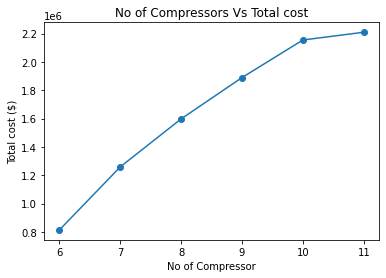

In [5]:
### Here, using the similar approach we find the optimized cost for the number of compressor=7, 9,11
### For compressor=7,9, 11, we found cost=1.259E6, 1.89E6, 2.21E6
compressor=[6,7,8,9,10,11]
cost=[813655,1.259E6,1.59793e+06,1.89E6,2.15531e+06,2.21E6]
plt.plot(compressor,cost, marker = 'o')
plt.xlabel('No of Compressor')
plt.ylabel('Total cost ($)')
plt.title("No of Compressors Vs Total cost")
plt.show()

In [6]:
#This cell is for check the optimized savings for the number of compressor= 6, number of areas =6 and number of planning periods in months=6

#####                Sets and Indices         #############
compressor = 6
area = 6
period= 6  

#####               Input Parameters           ##########

#unit heating cost in the months 
hc=[10.5,11,15,14.8,16, 17]
#unit cooling cost in the months
cc=[11.5,11.5,13,9.8,10,16]
## investment cost of the heating system installation of the area
f=[15000, 15500, 20200, 18760, 15000, 12000]
#Marginal cost of the j compressor added
S=[12000,13500,12500,14600,15400,15000]

#Average energy consuption in Mega Watt to heat up the area i in month m
## As there are lots of indexes in the E multidictionary,for simplicity, instead of assigning all the values of E manually,
## here we used randint() function to produce random values of E between 2000 to 5000.
E = {}
for i in range(area):    
    for m in range(period):    
        E[i,m] = random.randint(2000,5000) 

#Average energy consuption in Mega Watt to cool down the compressor j in month m
D={}
for j in range(compressor):    
   for m in range(period):    
        D[j,m] = random.randint(2000,5000) 

#extra energy consumption to heat up the area in m month
A=[1120,1130,1120.5,1030,1125.5,1128, 1125,1130, 1122,1125]
#extra energy consumption to cool down the compressor in m month
B=[1120.5,1030.5,1018.5,1122,1125.5,1026, 1120.5,1030, 1122,1225]

## Fixed investment cost for piping system of the area k to i
P={}
stored_key=[]
for k in range(area):    
    for i in range(area):    
        stored_key=P.keys()
        P[k,i] = random.randint(1000,2000) 

# Average energy loss from area i to area k in month m
L = {}
for k in range(area):    
    for i in range(area): 
     for m in range(period):  
       L[k,i,m] = random.randint(0,200) 

########    Model Deployment   #############
model = gp.Model('HRS')

#####          Decison Variable   ############
x = model.addVars(area, vtype=GRB.BINARY, name="x")
y = model.addVars(compressor, vtype=GRB.BINARY, name="y")
z = model.addVars(stored_key, vtype=GRB.BINARY, name="z")

#######     Assignment Constraint ##################
assignment1 =  model.addConstr(gp.quicksum(x[i] for i in range(area)) >= 1)
assignment2 =  model.addConstr(gp.quicksum(y[j] for j in range(compressor)) >= 1)
assignment3 =  model.addConstr(x[0] == 1)
assignment4 =  model.addConstrs((y[j-1] - y[j])  >= 0 for j in range(2,compressor) )

####         Routing Constraint  ##############
routing1 = model.addConstrs(gp.quicksum(z[k,i] for i in range(area)) <= 1 for k in range (area) if k != i)
routing2 = model.addConstrs(gp.quicksum(z[k,i] for k in range(area)) <= 1 for i in range (area) if i != k)
routing3 = model.addConstrs(x[i] - gp.quicksum(z[k,i] for k in range (area)) == 0 for i in range(area) if i != k)
routing4 = model.addConstrs(z[k,i]+z[i,k] <= 1 for k in range (area) for i in range(area) if k!=i )
  
#########          New Energy Consumption Constaint   ########

e1 = model.addConstrs(gp.quicksum(D[j,m]*y[j] for j in range(compressor)) <= 20000 for m in range(period))
e2 = model.addConstrs(gp.quicksum(E[i,m]*x[i] for i in range(area)) <= 20000 for m in range(period))
e3 = model.addConstrs(gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area))  <= 1500 for m in range(period) if k!=i)

###############            Objective: Maximize the savings                 ##########

### z1=Extra cost of cooling down for the compressors and heating up the areas
z1 = gp.quicksum(cc[m]*B[m] for m in range(period)) + gp.quicksum(hc[m]*A[m] for m in range(period))

### z2= Extra cost of additional areas and compressors that are not assigned to HRS
z2 = gp.quicksum(cc[m]* D[j,m]*(1-y[j]) for m in range(period) for j in range(compressor)) + gp.quicksum(hc[m]* E[i,m]*(1-x[i]) for m in range(period) for i in range(area)) 

### z3= Investment cost (Installation cost)
z3=  gp.quicksum(x[i]*f[i] for i in range(area)) + gp.quicksum(z[k,i]*P[k,i] for k in range(area) for i in range(area) if k!=i)

### z4= Investment cost (Marginal cost of adding extra compressors)
z4=  gp.quicksum(y[j]* S[j]  for j in range(compressor))

#### z5= Total cost for HRS installation 
z5= gp.quicksum(cc[m]* D[j,m]* y[j] for m in range(period) for j in range(compressor)) + gp.quicksum(hc[m]* E[i,m]*x[i] for m in range(period) for i in range(area)) 

##New  Objective: Minimize Energy Consumption  #############

### z6= Total energy Consumption for the HRS
z6=gp.quicksum(D[j,m]*y[j] for j in range(compressor) for m in range(period)) +  gp.quicksum(E[i,m]*x[i] for i in range(area)for m in range(period)) - gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area) for m in range(period) )

### Objective 2: maximization of savings ####
model.setObjective((z5-z1-z2), GRB.MAXIMIZE)
model.write('junk.lp')
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 64 rows, 48 columns and 248 nonzeros
Model fingerprint: 0x6416d5a1
Variable types: 0 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [5e+05, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective -328492.0000
Presolve removed 64 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 1.59146e+06 -328492 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.591455800000e+06, best bound 1.591455800000e+06, gap 0.0000%


In [7]:
#This cell is for checking the optimized savings for the number of compressor= 8, number of areas =6 and number of planning periods in months=6

#####                Sets and Indices         #############
## increasing number of compressors
compressor = 8
area = 6
period= 6  

#####               Input Parameters           ##########

#unit heating cost in the months 
hc=[10.5,11,15,14.8,16, 17]
#unit cooling cost in the months
cc=[11.5,11.5,13,9.8,10,16]
## investment cost of the heating system installation of the area
f=[15000, 15500, 20200, 18760, 15000, 12000]
#Marginal cost of the j compressor added
S=[12000,13500,12500,14600,15400,15000, 14600,15800]

#Average energy consuption in Mega Watt to heat up the area i in month m
## As there are lots of indexes in the E multidictionary,for simplicity, instead of assigning all the values of E manually,
## here we used randint() function to produce random values of E between 2000 to 5000.
E = {}
for i in range(area):    
    for m in range(period):    
        E[i,m] = random.randint(2000,5000) 

#Average energy consuption in Mega Watt to cool down the compressor j in month m
D={}
for j in range(compressor):    
   for m in range(period):    
        D[j,m] = random.randint(2000,5000) 

#extra energy consumption to heat up the area in m month
A=[1120,1130,1120.5,1030,1125.5,1128, 1125,1130, 1122,1125]
#extra energy consumption to cool down the compressor in m month
B=[1120.5,1030.5,1018.5,1122,1125.5,1026, 1120.5,1030, 1122,1225]

## Fixed investment cost for piping system of the area k to i
P={}
stored_key=[]
for k in range(area):    
    for i in range(area):    
        stored_key=P.keys()
        P[k,i] = random.randint(1000,2000) 

# Average energy loss from area i to area k in month m
L = {}
for k in range(area):    
    for i in range(area): 
     for m in range(period):  
       L[k,i,m] = random.randint(0,200) 

########    Model Deployment   #############
model = gp.Model('HRS')

#####          Decison Variable   ############
x = model.addVars(area, vtype=GRB.BINARY, name="x")
y = model.addVars(compressor, vtype=GRB.BINARY, name="y")
z = model.addVars(stored_key, vtype=GRB.BINARY, name="z")

#######     Assignment Constraint ##################
assignment1 =  model.addConstr(gp.quicksum(x[i] for i in range(area)) >= 1)
assignment2 =  model.addConstr(gp.quicksum(y[j] for j in range(compressor)) >= 1)
assignment3 =  model.addConstr(x[0] == 1)
assignment4 =  model.addConstrs((y[j-1] - y[j])  >= 0 for j in range(2,compressor) )

####         Routing Constraint  ##############
routing1 = model.addConstrs(gp.quicksum(z[k,i] for i in range(area)) <= 1 for k in range (area) if k != i)
routing2 = model.addConstrs(gp.quicksum(z[k,i] for k in range(area)) <= 1 for i in range (area) if i != k)
routing3 = model.addConstrs(x[i] - gp.quicksum(z[k,i] for k in range (area)) == 0 for i in range(area) if i != k)
routing4 = model.addConstrs(z[k,i]+z[i,k] <= 1 for k in range (area) for i in range(area) if k!=i )
  
#########          New Energy Consumption Constaint   ########

e1 = model.addConstrs(gp.quicksum(D[j,m]*y[j] for j in range(compressor)) <= 20000 for m in range(period))
e2 = model.addConstrs(gp.quicksum(E[i,m]*x[i] for i in range(area)) <= 20000 for m in range(period))
e3 = model.addConstrs(gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area))  <= 1500 for m in range(period) if k!=i)

###############            Objective: Maximize the savings                 ##########

### z1=Extra cost of cooling down for the compressors and heating up the areas
z1 = gp.quicksum(cc[m]*B[m] for m in range(period)) + gp.quicksum(hc[m]*A[m] for m in range(period))

### z2= Extra cost of additional areas and compressors that are not assigned to HRS
z2 = gp.quicksum(cc[m]* D[j,m]*(1-y[j]) for m in range(period) for j in range(compressor)) + gp.quicksum(hc[m]* E[i,m]*(1-x[i]) for m in range(period) for i in range(area)) 

### z3= Investment cost (Installation cost)
z3=  gp.quicksum(x[i]*f[i] for i in range(area)) + gp.quicksum(z[k,i]*P[k,i] for k in range(area) for i in range(area) if k!=i)

### z4= Investment cost (Marginal cost of adding extra compressors)
z4=  gp.quicksum(y[j]* S[j]  for j in range(compressor))

#### z5= Total cost for HRS installation 
z5= gp.quicksum(cc[m]* D[j,m]* y[j] for m in range(period) for j in range(compressor)) + gp.quicksum(hc[m]* E[i,m]*x[i] for m in range(period) for i in range(area)) 

##New  Objective: Minimize Energy Consumption  #############

### z6= Total energy Consumption for the HRS
z6=gp.quicksum(D[j,m]*y[j] for j in range(compressor) for m in range(period)) +  gp.quicksum(E[i,m]*x[i] for i in range(area)for m in range(period)) - gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area) for m in range(period) )

### Objective 2: maximization of savings ####
model.setObjective((z5-z1-z2), GRB.MAXIMIZE)
model.write('junk.lp')
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 66 rows, 50 columns and 266 nonzeros
Model fingerprint: 0x857457d4
Variable types: 0 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [4e+05, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective -749761.1000
Presolve removed 66 rows and 50 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 977098 -749761 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.770985000000e+05, best bound 9.770985000000e+05, gap 0.0000%


In [8]:
#This cell is for check the optimized savings for the number of compressor= 10, number of areas =6 and number of planning periods in months=6

#####                Sets and Indices         #############
### increasing the number of compressors
compressor = 10
area = 6
period= 6  

#####               Input Parameters           ##########

#unit heating cost in the months 
hc=[10.5,11,15,14.8,16, 17]
#unit cooling cost in the months
cc=[11.5,11.5,13,9.8,10,16]
## investment cost of the heating system installation of the area
f=[15000, 15500, 20200, 18760, 15000, 12000]
#Marginal cost of the j compressor added
S=[12000,13500,12500,14600,15400,15000, 14600,15800, 14600,15400]

#Average energy consuption in Mega Watt to heat up the area i in month m
## As there are lots of indexes in the E multidictionary,for simplicity, instead of assigning all the values of E manually,
## here we used randint() function to produce random values of E between 2000 to 5000.
E = {}
for i in range(area):    
    for m in range(period):    
        E[i,m] = random.randint(2000,5000) 

#Average energy consuption in Mega Watt to cool down the compressor j in month m
D={}
for j in range(compressor):    
   for m in range(period):    
        D[j,m] = random.randint(2000,5000) 

#extra energy consumption to heat up the area in m month
A=[1120,1130,1120.5,1030,1125.5,1128, 1125,1130, 1122,1125]
#extra energy consumption to cool down the compressor in m month
B=[1120.5,1030.5,1018.5,1122,1125.5,1026, 1120.5,1030, 1122,1225]

## Fixed investment cost for piping system of the area k to i
P={}
stored_key=[]
for k in range(area):    
    for i in range(area):    
        stored_key=P.keys()
        P[k,i] = random.randint(1000,2000) 

# Average energy loss from area i to area k in month m
L = {}
for k in range(area):    
    for i in range(area): 
     for m in range(period):  
       L[k,i,m] = random.randint(0,200) 

########    Model Deployment   #############
model = gp.Model('HRS')

#####          Decison Variable   ############
x = model.addVars(area, vtype=GRB.BINARY, name="x")
y = model.addVars(compressor, vtype=GRB.BINARY, name="y")
z = model.addVars(stored_key, vtype=GRB.BINARY, name="z")

#######     Assignment Constraint ##################
assignment1 =  model.addConstr(gp.quicksum(x[i] for i in range(area)) >= 1)
assignment2 =  model.addConstr(gp.quicksum(y[j] for j in range(compressor)) >= 1)
assignment3 =  model.addConstr(x[0] == 1)
assignment4 =  model.addConstrs((y[j-1] - y[j])  >= 0 for j in range(2,compressor) )

####         Routing Constraint  ##############
routing1 = model.addConstrs(gp.quicksum(z[k,i] for i in range(area)) <= 1 for k in range (area) if k != i)
routing2 = model.addConstrs(gp.quicksum(z[k,i] for k in range(area)) <= 1 for i in range (area) if i != k)
routing3 = model.addConstrs(x[i] - gp.quicksum(z[k,i] for k in range (area)) == 0 for i in range(area) if i != k)
routing4 = model.addConstrs(z[k,i]+z[i,k] <= 1 for k in range (area) for i in range(area) if k!=i )
  
#########          New Energy Consumption Constaint   ########

e1 = model.addConstrs(gp.quicksum(D[j,m]*y[j] for j in range(compressor)) <= 20000 for m in range(period))
e2 = model.addConstrs(gp.quicksum(E[i,m]*x[i] for i in range(area)) <= 20000 for m in range(period))
e3 = model.addConstrs(gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area))  <= 1500 for m in range(period) if k!=i)

###############            Objective: Maximize the savings                 ##########

### z1=Extra cost of cooling down for the compressors and heating up the areas
z1 = gp.quicksum(cc[m]*B[m] for m in range(period)) + gp.quicksum(hc[m]*A[m] for m in range(period))

### z2= Extra cost of additional areas and compressors that are not assigned to HRS
z2 = gp.quicksum(cc[m]* D[j,m]*(1-y[j]) for m in range(period) for j in range(compressor)) + gp.quicksum(hc[m]* E[i,m]*(1-x[i]) for m in range(period) for i in range(area)) 

### z3= Investment cost (Installation cost)
z3=  gp.quicksum(x[i]*f[i] for i in range(area)) + gp.quicksum(z[k,i]*P[k,i] for k in range(area) for i in range(area) if k!=i)

### z4= Investment cost (Marginal cost of adding extra compressors)
z4=  gp.quicksum(y[j]* S[j]  for j in range(compressor))

#### z5= Total cost for HRS installation 
z5= gp.quicksum(cc[m]* D[j,m]* y[j] for m in range(period) for j in range(compressor)) + gp.quicksum(hc[m]* E[i,m]*x[i] for m in range(period) for i in range(area)) 

##New  Objective: Minimize Energy Consumption  #############

### z6= Total energy Consumption for the HRS
z6=gp.quicksum(D[j,m]*y[j] for j in range(compressor) for m in range(period)) +  gp.quicksum(E[i,m]*x[i] for i in range(area)for m in range(period)) - gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area) for m in range(period) )

### Objective 2: maximization of savings ####
model.setObjective((z5-z1-z2), GRB.MAXIMIZE)
model.write('junk.lp')
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 68 rows, 52 columns and 284 nonzeros
Model fingerprint: 0x771165b0
Variable types: 0 continuous, 52 integer (52 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [4e+05, 7e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective -1000689.300
Presolve removed 68 rows and 52 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 1.06893e+06 -1.00069e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.068925100000e+06, best bound 1.068925100000e+06, gap 0.0000%


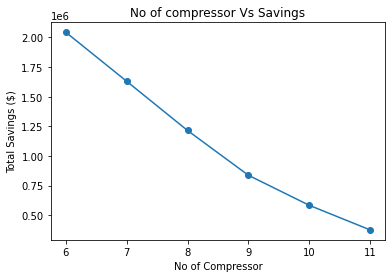

In [9]:
### Here, using the similar approach we find the optimized savings for the number of compressor=7, 9,11
### For compressor=7,9, 11 we found savings=1.63e6, 837323, 376594
compressor=[6,7,8,9,10,11]
savings=[2.04331e+06,1.63e6,1.21488e+06, 837323, 584014, 376594 ]
plt.plot(compressor,savings, marker = 'o')
plt.xlabel('No of Compressor')
plt.ylabel('Total Savings ($)')
plt.title("No of compressor Vs Savings")
plt.show()

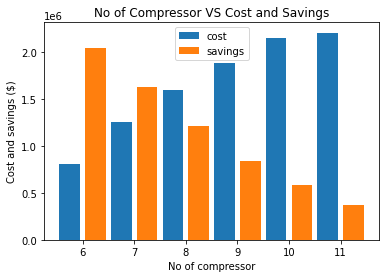

In [22]:
### Here, total optimized cost Vs total optimized savings are represented.
compressor=[6,7,8,9,10,11]
cost=[813655,1.259E6,1.59793e+06,1.89E6,2.15531e+06,2.21E6]
savings=[2.04331e+06,1.63e6,1.21488e+06, 837323, 584014, 376594 ]
X_axis = np.arange(6,12)
plt.bar(X_axis - 0.25,cost, 0.4, label='cost')
plt.bar(X_axis + 0.25,savings,0.4, label='savings')
plt.xlabel('No of compressor')
plt.ylabel('Cost and savings ($)')
plt.title('No of Compressor VS Cost and Savings')
plt.legend()


In [12]:
#This cell is for checking the optimized investment cost for the number of compressor= 6, number of areas =6 and number of planning periods in months=6

#####                Sets and Indices         #############
compressor = 6
area = 6
period= 6  

#####               Input Parameters           ##########

#unit heating cost in the months 
hc=[10.5,11,15,14.8,16, 17]
#unit cooling cost in the months
cc=[11.5,11.5,13,9.8,10,16]
## investment cost of the heating system installation of the area
f=[15000, 15500, 20200, 18760, 15000, 12000]
#Marginal cost of the j compressor added
S=[12000,13500,12500,14600,15400,15000]

#Average energy consumption in Mega Watt to heat up the area i in month m
## As there are lots of indexes in the E multidictionary,for simplicity, instead of assigning all the values of E manually,
## here we used randint() function to produce random values of E between 2000 to 5000.
E = {}
for i in range(area):    
    for m in range(period):    
        E[i,m] = random.randint(2000,5000) 

#Average energy consuption in Mega Watt to cool down the compressor j in month m
D={}
for j in range(compressor):    
   for m in range(period):    
        D[j,m] = random.randint(2000,5000) 

#extra energy consumption to heat up the area in m month
A=[1120,1130,1120.5,1030,1125.5,1128, 1125,1130, 1122,1125]
#extra energy consumption to cool down the compressor in m month
B=[1120.5,1030.5,1018.5,1122,1125.5,1026, 1120.5,1030, 1122,1225]

## Fixed investment cost for piping system of the area k to i
P={}
stored_key=[]
for k in range(area):    
    for i in range(area):    
        stored_key=P.keys()
        P[k,i] = random.randint(1000,2000) 

# Average energy loss from area i to area k in month m
L = {}
for k in range(area):    
    for i in range(area): 
     for m in range(period):  
       L[k,i,m] = random.randint(0,200) 

########    Model Deployment   #############
model = gp.Model('HRS')

#####          Decison Variable   ############
x = model.addVars(area, vtype=GRB.BINARY, name="x")
y = model.addVars(compressor, vtype=GRB.BINARY, name="y")
z = model.addVars(stored_key, vtype=GRB.BINARY, name="z")

#######     Assignment Constraint ##################
assignment1 =  model.addConstr(gp.quicksum(x[i] for i in range(area)) >= 1)
assignment2 =  model.addConstr(gp.quicksum(y[j] for j in range(compressor)) >= 1)
assignment3 =  model.addConstr(x[0] == 1)
assignment4 =  model.addConstrs((y[j-1] - y[j])  >= 0 for j in range(2,compressor) )

####         Routing Constraint  ##############
routing1 = model.addConstrs(gp.quicksum(z[k,i] for i in range(area)) <= 1 for k in range (area) if k != i)
routing2 = model.addConstrs(gp.quicksum(z[k,i] for k in range(area)) <= 1 for i in range (area) if i != k)
routing3 = model.addConstrs(x[i] - gp.quicksum(z[k,i] for k in range (area)) == 0 for i in range(area) if i != k)
routing4 = model.addConstrs(z[k,i]+z[i,k] <= 1 for k in range (area) for i in range(area) if k!=i )

###############            Objective: Minimize the investment cost (Installation cost + Marginal cost)                 ##########

### z3= Investment cost (Installation cost)
z3=  gp.quicksum(x[i]*f[i] for i in range(area)) + gp.quicksum(z[k,i]*P[k,i] for k in range(area) for i in range(area) if k!=i)

### z4= Investment cost (Marginal cost of adding extra compressors)
z4=  gp.quicksum(y[j]* S[j]  for j in range(compressor))

model.setObjective((z3+z4), GRB.MINIMIZE)
model.write('junk.lp')
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 52 rows, 48 columns and 176 nonzeros
Model fingerprint: 0x881d2c2c
Variable types: 0 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+03, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 30377.000000
Presolve removed 52 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 27000 30377 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.700000000000e+04, best bound 2.700000000000e+04, gap 0.0000%


In [13]:
#This cell is for checking the optimized investment cost for the number of compressor= 8, number of areas =6 and number of planning periods in months=6

#####                Sets and Indices         #############
### increasing the number of compressors
compressor = 8
area = 6
period= 6  

#####               Input Parameters           ##########

#unit heating cost in the months 
hc=[10.5,11,15,14.8,16, 17]
#unit cooling cost in the months
cc=[11.5,11.5,13,9.8,10,16]
## investment cost of the heating system installation of the area
f=[15000, 15500, 20200, 18760, 15000, 12000]
#Marginal cost of the j compressor added
S=[12000,13500,12500,14600,15400,15000, 14600,15400]

#Average energy consuption in Mega Watt to heat up the area i in month m
## As there are lots of indexes in the E multidictionary,for simplicity, instead of assigning all the values of E manually,
## here we used randint() function to produce random values of E between 2000 to 5000.
E = {}
for i in range(area):    
    for m in range(period):    
        E[i,m] = random.randint(2000,5000) 

#Average energy consuption in Mega Watt to cool down the compressor j in month m
D={}
for j in range(compressor):    
   for m in range(period):    
        D[j,m] = random.randint(2000,5000) 

#extra energy consumption to heat up the area in m month
A=[1120,1130,1120.5,1030,1125.5,1128, 1125,1130, 1122,1125]
#extra energy consumption to cool down the compressor in m month
B=[1120.5,1030.5,1018.5,1122,1125.5,1026, 1120.5,1030, 1122,1225]

## Fixed investment cost for piping system of the area k to i
P={}
stored_key=[]
for k in range(area):    
    for i in range(area):    
        stored_key=P.keys()
        P[k,i] = random.randint(1000,2000) 

# Average energy loss from area i to area k in month m
L = {}
for k in range(area):    
    for i in range(area): 
     for m in range(period):  
       L[k,i,m] = random.randint(0,200) 

########    Model Deployment   #############
model = gp.Model('HRS')

#####          Decison Variable   ############
x = model.addVars(area, vtype=GRB.BINARY, name="x")
y = model.addVars(compressor, vtype=GRB.BINARY, name="y")
z = model.addVars(stored_key, vtype=GRB.BINARY, name="z")

#######     Assignment Constraint ##################
assignment1 =  model.addConstr(gp.quicksum(x[i] for i in range(area)) >= 1)
assignment2 =  model.addConstr(gp.quicksum(y[j] for j in range(compressor)) >= 1)
assignment3 =  model.addConstr(x[0] == 1)
assignment4 =  model.addConstrs((y[j-1] - y[j])  >= 0 for j in range(2,compressor) )

####         Routing Constraint  ##############
routing1 = model.addConstrs(gp.quicksum(z[k,i] for i in range(area)) <= 1 for k in range (area) if k != i)
routing2 = model.addConstrs(gp.quicksum(z[k,i] for k in range(area)) <= 1 for i in range (area) if i != k)
routing3 = model.addConstrs(x[i] - gp.quicksum(z[k,i] for k in range (area)) == 0 for i in range(area) if i != k)
routing4 = model.addConstrs(z[k,i]+z[i,k] <= 1 for k in range (area) for i in range(area) if k!=i )

###############            Objective: Minimize the investment cost (Installation cost + Marginal cost)                 ##########

### z3= Investment cost (Installation cost)
z3=  gp.quicksum(x[i]*f[i] for i in range(area)) + gp.quicksum(z[k,i]*P[k,i] for k in range(area) for i in range(area) if k!=i)

### z4= Investment cost (Marginal cost of adding extra compressors)
z4=  gp.quicksum(y[j]* S[j]  for j in range(compressor))

model.setObjective((z3+z4), GRB.MINIMIZE)
model.write('junk.lp')
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 54 rows, 50 columns and 182 nonzeros
Model fingerprint: 0xe56362bf
Variable types: 0 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+03, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 30422.000000
Presolve removed 54 rows and 50 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 27000 30422 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.700000000000e+04, best bound 2.700000000000e+04, gap 0.0000%


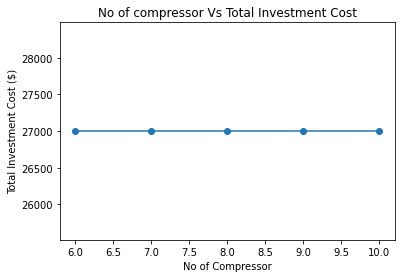

In [14]:

### Here, using the similar approach we find the optimized investment cost for the number of compressor=7,9,10
### when compressor=7,9,10  z3=27000,27000,27000
compressor=[6,7,8,9,10]
investment_cost=[27000,27000,27000,27000,27000]
plt.plot(compressor,investment_cost, marker = 'o')
plt.xlabel('No of Compressor')
plt.ylabel('Total Investment Cost ($)')
plt.title("No of compressor Vs Total Investment Cost")
plt.show()

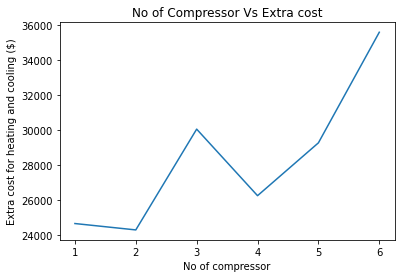

In [15]:
### Here, we calculated the extra cost of cooling the compressors and heating the areas for the number of compressor=1,2,3,4,5,6
heating_cost=[]
cooling_cost=[]
total_extra_cost=[]

no_of_compressor= np.arange(1,7)
for i in range(0, len(hc)):
    heating_cost.append(hc[i] * A[i])
for i in range(0, len(cc)):
    cooling_cost.append(cc[i] * B[i])

total_extra_cost=np.add(heating_cost,cooling_cost).tolist()
plt.plot(no_of_compressor,total_extra_cost)
plt.xlabel('No of compressor')
plt.ylabel('Extra cost for heating and cooling ($)')
plt.title("No of Compressor Vs Extra cost")
plt.show()

In [16]:
#This cell is for checking the optimized Energy Consumption number of compressor= 6, number of areas =6 and number of planning periods in months=6

#####                Sets and Indices         #############
compressor = 6
area = 6
period= 6  

#####               Input Parameters           ##########

#unit heating cost in the months 
hc=[10.5,11,15,14.8,16, 17]
#unit cooling cost in the months
cc=[11.5,11.5,13,9.8,10,16]
## investment cost of the heating system installation of the area
f=[15000, 15500, 20200, 18760, 15000, 12000]
#Marginal cost of the j compressor added
S=[12000,13500,12500,14600,15400,15000]

#Average energy consumption in Mega Watt to heat up the area i in month m

## Because of 6 areas and 6 periods, there are lots of indexes in the E multidictionary,for simplicity, instead of assigning all the values of E manually,
## here we used randint() function to produce random values of E between 2000 to 5000. Because of the several randint() function the optimization
## output giving slightly different values in each time of running the codes
E = {}
for i in range(area):    
    for m in range(period):    
        E[i,m] = random.randint(2000,5000) 

#Average energy consumption in Mega Watt to cool down the compressor j in month m
D={}
for j in range(compressor):    
   for m in range(period):    
        D[j,m] = random.randint(2000,5000) 

#extra energy consumption to heat up the area in m month
A=[1120,1130,1120.5,1030,1125.5,1128, 1125,1130, 1122,1125]
#extra energy consumption to cool down the compressor in m month
B=[1120.5,1030.5,1018.5,1122,1125.5,1026, 1120.5,1030, 1122,1225]

## Fixed investment cost for piping system of the area k to i
P={}
stored_key=[]
for k in range(area):    
    for i in range(area):    
        stored_key=P.keys()
        P[k,i] = random.randint(1000,2000) 

# Average energy loss from area i to area k in month m
L = {}
for k in range(area):    
    for i in range(area): 
     for m in range(period):  
       L[k,i,m] = random.randint(0,200) 

########    Model Deployment   #############
model = gp.Model('HRS')

#####          Decison Variable   ############
x = model.addVars(area, vtype=GRB.BINARY, name="x")
y = model.addVars(compressor, vtype=GRB.BINARY, name="y")
z = model.addVars(stored_key, vtype=GRB.BINARY, name="z")

#######     Assignment Constraint ##################
assignment1 =  model.addConstr(gp.quicksum(x[i] for i in range(area)) >= 1)
assignment2 =  model.addConstr(gp.quicksum(y[j] for j in range(compressor)) >= 1)
assignment3 =  model.addConstr(x[0] == 1)
assignment4 =  model.addConstrs((y[j-1] - y[j])  >= 0 for j in range(2,compressor) )

####         Routing Constraint  ##############
routing1 = model.addConstrs(gp.quicksum(z[k,i] for i in range(area)) <= 1 for k in range (area) if k != i)
routing2 = model.addConstrs(gp.quicksum(z[k,i] for k in range(area)) <= 1 for i in range (area) if i != k)
routing3 = model.addConstrs(x[i] - gp.quicksum(z[k,i] for k in range (area)) == 0 for i in range(area) if i != k)
routing4 = model.addConstrs(z[k,i]+z[i,k] <= 1 for k in range (area) for i in range(area) if k!=i )
  
#########          New Energy Consumption Constaint   ########

e1 = model.addConstrs(gp.quicksum(D[j,m]*y[j] for j in range(compressor)) <= 20000 for m in range(period))
e2 = model.addConstrs(gp.quicksum(E[i,m]*x[i] for i in range(area)) <= 20000 for m in range(period))
e3 = model.addConstrs(gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area))  <= 1500 for m in range(period) if k!=i)

###############            Objective: Minimize Energy Consumption of HRS                 ##########

### z6= Total energy Consumption for the HRS
z6= gp.quicksum(D[j,m]*y[j] for j in range(compressor) for m in range(period)) +  gp.quicksum(E[i,m]*x[i] for i in range(area)for m in range(period)) - gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area) for m in range(period) )

### Objective 3: Minimization of Energy Consumption ####
model.setObjective(z6, GRB.MINIMIZE)
model.write('junk.lp')
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 64 rows, 48 columns and 248 nonzeros
Model fingerprint: 0x0e7fa19c
Variable types: 0 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [4e+02, 3e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 43691.000000
Presolve removed 64 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 37436 43691 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.743600000000e+04, best bound 3.743600000000e+04, gap 0.0000%


In [17]:
#This cell is for checking the optimized Energy Consumption number of compressor= 8, number of areas =6 and number of planning periods in months=6

#####                Sets and Indices         #############
compressor = 8
area = 6
period= 6  

#####               Input Parameters           ##########

#unit heating cost in the months 
hc=[10.5,11,15,14.8,16, 17]
#unit cooling cost in the months
cc=[11.5,11.5,13,9.8,10,16]
## investment cost of the heating system installation of the area
f=[15000, 15500, 20200, 18760, 15000, 12000]
#Marginal cost of the j compressor added
S=[12000,13500,12500,14600,15400,15000, 14600,15800]

#Average energy consumption in Mega Watt to heat up the area i in month m

## Because of 6 areas and 6 periods, there are lots of indexes in the E multidictionary,for simplicity, instead of assigning all the values of E manually,
## here we used randint() function to produce random values of E between 2000 to 5000. Because of the several randint() function the optimization
## output giving slightly different values in each time of running the codes
E = {}
for i in range(area):    
    for m in range(period):    
        E[i,m] = random.randint(2000,5000) 

#Average energy consumption in Mega Watt to cool down the compressor j in month m
D={}
for j in range(compressor):    
   for m in range(period):    
        D[j,m] = random.randint(2000,5000) 

#extra energy consumption to heat up the area in m month
A=[1120,1130,1120.5,1030,1125.5,1128, 1125,1130, 1122,1125]
#extra energy consumption to cool down the compressor in m month
B=[1120.5,1030.5,1018.5,1122,1125.5,1026, 1120.5,1030, 1122,1225]

## Fixed investment cost for piping system of the area k to i
P={}
stored_key=[]
for k in range(area):    
    for i in range(area):    
        stored_key=P.keys()
        P[k,i] = random.randint(1000,2000) 

# Average energy loss from area i to area k in month m
L = {}
for k in range(area):    
    for i in range(area): 
     for m in range(period):  
       L[k,i,m] = random.randint(0,200) 

########    Model Deployment   #############
model = gp.Model('HRS')

#####          Decison Variable   ############
x = model.addVars(area, vtype=GRB.BINARY, name="x")
y = model.addVars(compressor, vtype=GRB.BINARY, name="y")
z = model.addVars(stored_key, vtype=GRB.BINARY, name="z")

#######     Assignment Constraint ##################
assignment1 =  model.addConstr(gp.quicksum(x[i] for i in range(area)) >= 1)
assignment2 =  model.addConstr(gp.quicksum(y[j] for j in range(compressor)) >= 1)
assignment3 =  model.addConstr(x[0] == 1)
assignment4 =  model.addConstrs((y[j-1] - y[j])  >= 0 for j in range(2,compressor) )

####         Routing Constraint  ##############
routing1 = model.addConstrs(gp.quicksum(z[k,i] for i in range(area)) <= 1 for k in range (area) if k != i)
routing2 = model.addConstrs(gp.quicksum(z[k,i] for k in range(area)) <= 1 for i in range (area) if i != k)
routing3 = model.addConstrs(x[i] - gp.quicksum(z[k,i] for k in range (area)) == 0 for i in range(area) if i != k)
routing4 = model.addConstrs(z[k,i]+z[i,k] <= 1 for k in range (area) for i in range(area) if k!=i )
  
#########          New Energy Consumption Constaint   ########

e1 = model.addConstrs(gp.quicksum(D[j,m]*y[j] for j in range(compressor)) <= 20000 for m in range(period))
e2 = model.addConstrs(gp.quicksum(E[i,m]*x[i] for i in range(area)) <= 20000 for m in range(period))
e3 = model.addConstrs(gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area))  <= 1500 for m in range(period) if k!=i)

###############            Objective: Minimize Energy Consumption of HRS                 ##########

### z6= Total energy Consumption for the HRS
z6= gp.quicksum(D[j,m]*y[j] for j in range(compressor) for m in range(period)) +  gp.quicksum(E[i,m]*x[i] for i in range(area)for m in range(period)) - gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area) for m in range(period) )

### Objective 3: Minimization of Energy Consumption ####
model.setObjective(z6, GRB.MINIMIZE)
model.write('junk.lp')
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 66 rows, 50 columns and 266 nonzeros
Model fingerprint: 0xd4a7d506
Variable types: 0 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [3e+02, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 41213.000000
Presolve removed 66 rows and 50 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 41071 41213 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.107100000000e+04, best bound 4.107100000000e+04, gap 0.0000%


In [18]:
#This cell is for checking the optimized Energy Consumption number of compressor= 8, number of areas =6 and number of planning periods in months=6

#####                Sets and Indices         #############
compressor = 10
area = 6
period= 6  

#####               Input Parameters           ##########

#unit heating cost in the months 
hc=[10.5,11,15,14.8,16, 17]
#unit cooling cost in the months
cc=[11.5,11.5,13,9.8,10,16]
## investment cost of the heating system installation of the area
f=[15000, 15500, 20200, 18760, 15000, 12000]
#Marginal cost of the j compressor added
S=[12000,13500,12500,14600,15400,15000, 14600,15800, 14600,15400]

#Average energy consumption in Mega Watt to heat up the area i in month m

## Because of 6 areas and 6 periods, there are lots of indexes in the E multidictionary,for simplicity, instead of assigning all the values of E manually,
## here we used randint() function to produce random values of E between 2000 to 5000. Because of the several randint() function the optimization
## output giving slightly different values in each time of running the codes
E = {}
for i in range(area):    
    for m in range(period):    
        E[i,m] = random.randint(2000,5000) 

#Average energy consumption in Mega Watt to cool down the compressor j in month m
D={}
for j in range(compressor):    
   for m in range(period):    
        D[j,m] = random.randint(2000,5000) 

#extra energy consumption to heat up the area in m month
A=[1120,1130,1120.5,1030,1125.5,1128, 1125,1130, 1122,1125]
#extra energy consumption to cool down the compressor in m month
B=[1120.5,1030.5,1018.5,1122,1125.5,1026, 1120.5,1030, 1122,1225]

## Fixed investment cost for piping system of the area k to i
P={}
stored_key=[]
for k in range(area):    
    for i in range(area):    
        stored_key=P.keys()
        P[k,i] = random.randint(1000,2000) 

# Average energy loss from area i to area k in month m
L = {}
for k in range(area):    
    for i in range(area): 
     for m in range(period):  
       L[k,i,m] = random.randint(0,200) 

########    Model Deployment   #############
model = gp.Model('HRS')

#####          Decison Variable   ############
x = model.addVars(area, vtype=GRB.BINARY, name="x")
y = model.addVars(compressor, vtype=GRB.BINARY, name="y")
z = model.addVars(stored_key, vtype=GRB.BINARY, name="z")

#######     Assignment Constraint ##################
assignment1 =  model.addConstr(gp.quicksum(x[i] for i in range(area)) >= 1)
assignment2 =  model.addConstr(gp.quicksum(y[j] for j in range(compressor)) >= 1)
assignment3 =  model.addConstr(x[0] == 1)
assignment4 =  model.addConstrs((y[j-1] - y[j])  >= 0 for j in range(2,compressor) )

####         Routing Constraint  ##############
routing1 = model.addConstrs(gp.quicksum(z[k,i] for i in range(area)) <= 1 for k in range (area) if k != i)
routing2 = model.addConstrs(gp.quicksum(z[k,i] for k in range(area)) <= 1 for i in range (area) if i != k)
routing3 = model.addConstrs(x[i] - gp.quicksum(z[k,i] for k in range (area)) == 0 for i in range(area) if i != k)
routing4 = model.addConstrs(z[k,i]+z[i,k] <= 1 for k in range (area) for i in range(area) if k!=i )
  
#########          New Energy Consumption Constaint   ########

e1 = model.addConstrs(gp.quicksum(D[j,m]*y[j] for j in range(compressor)) <= 20000 for m in range(period))
e2 = model.addConstrs(gp.quicksum(E[i,m]*x[i] for i in range(area)) <= 20000 for m in range(period))
e3 = model.addConstrs(gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area))  <= 1500 for m in range(period) if k!=i)

###############            Objective: Minimize Energy Consumption of HRS                 ##########

### z6= Total energy Consumption for the HRS
z6= gp.quicksum(D[j,m]*y[j] for j in range(compressor) for m in range(period)) +  gp.quicksum(E[i,m]*x[i] for i in range(area)for m in range(period)) - gp.quicksum(L[k,i,m]*z[k,i] for i in range(area) for k in range(area) for m in range(period) )

### Objective 3: Minimization of Energy Consumption ####
model.setObjective(z6, GRB.MINIMIZE)
model.write('junk.lp')
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 68 rows, 52 columns and 284 nonzeros
Model fingerprint: 0xe3fd8a86
Variable types: 0 continuous, 52 integer (52 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [3e+02, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 37157.000000
Presolve removed 68 rows and 52 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 37115 37157 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.711500000000e+04, best bound 3.711500000000e+04, gap 0.0000%


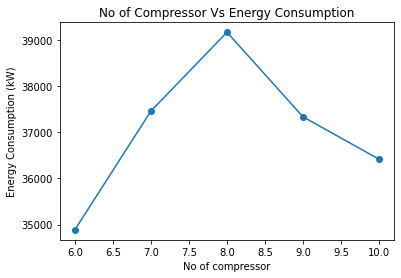

In [19]:
### Here, using the similar approach we find the optimized energy consumption for the number of compressor=7,9
##For compressor 7, 9 we found energy consumption= 37458, 37334

### Here, Number of compressor Vs optimized energy consumptions are displayed.
energy_consumption=[34884,37458, 39167, 37334,36414]
compressor=[6,7,8,9,10]
plt.plot(compressor, energy_consumption,marker = 'o')
plt.xlabel('No of compressor')
plt.ylabel('Energy Consumption (kW)')
plt.title("No of Compressor Vs Energy Consumption")
plt.show()


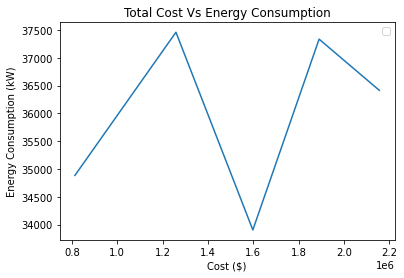

In [23]:
##Here total optimized cost Vs optimized energy consumption graph is presented for number of compressor=6,7,8,9,10

cost=[813655,1.259E6,1.59793e+06,1.89E6,2.15531e+06]
energy_consumption=[34884,37458, 33904, 37334,36414]
plt.plot(cost,energy_consumption)
plt.xlabel('Cost ($)')
plt.ylabel('Energy Consumption (kW)')
plt.title('Total Cost Vs Energy Consumption')
plt.legend()